In [2]:
import shelve
from pathlib import Path
from typing import *

import torch

from utils.dataset import UnclusteredProteinChainDataset, idealize_backbone_coords
from utils.model import FlowModel, FlowModelModuleConfig
import utils.rigid_utils as ur 
import utils.utility_functions as uf

file_path = Path('.').resolve()
print(file_path)

def compute_fape(
    pred_frames: ur.Rigid,
    target_frames: ur.Rigid,
    frames_mask: torch.Tensor,
    pred_positions: torch.Tensor,
    target_positions: torch.Tensor,
    positions_mask: torch.Tensor,
    length_scale: float,
    l1_clamp_distance: Optional[float] = None,
    eps=1e-8, ignore_nan=True,
) -> torch.Tensor:
    """
        Computes FAPE loss.

        Args:
            pred_frames:
                [*, N_frames] Rigid object of predicted frames
            target_frames:
                [*, N_frames] Rigid object of ground truth frames
            frames_mask:
                [*, N_frames] binary mask for the frames
            pred_positions:
                [*, N_pts, 3] predicted atom positions
            target_positions:
                [*, N_pts, 3] ground truth positions
            positions_mask:
                [*, N_pts] positions mask
            length_scale:
                Length scale by which the loss is divided
            l1_clamp_distance:
                Cutoff above which distance errors are disregarded
            eps:
                Small value used to regularize denominators
        Returns:
            [*] loss tensor
    """
    # [*, N_frames, N_pts, 3]
    local_pred_pos = pred_frames.invert()[..., None].apply(
        pred_positions[..., None, :, :],
    )
    local_target_pos = target_frames.invert()[..., None].apply(
        target_positions[..., None, :, :],
    )

    error_dist = torch.sqrt(
        torch.sum((local_pred_pos - local_target_pos) ** 2, dim=-1) + eps
    )

    if l1_clamp_distance is not None:
        error_dist = torch.clamp(error_dist, min=0, max=l1_clamp_distance)

    normed_error = error_dist / length_scale
    normed_error = normed_error * frames_mask[..., None]
    normed_error = normed_error * positions_mask[..., None, :]
    if ignore_nan:
        normed_error = torch.nan_to_num(normed_error)

    # FP16-friendly averaging. Roughly equivalent to:
    #
    # norm_factor = (
    #     torch.sum(frames_mask, dim=-1) *
    #     torch.sum(positions_mask, dim=-1)
    # )
    # normed_error = torch.sum(normed_error, dim=(-1, -2)) / (eps + norm_factor)
    #
    # ("roughly" because eps is necessarily duplicated in the latter)
    normed_error = torch.sum(normed_error, dim=-1)
    normed_error = (
        normed_error / (eps + torch.sum(frames_mask, dim=-1))[..., None]
    )
    normed_error = torch.sum(normed_error, dim=-1)
    normed_error = normed_error / (eps + torch.sum(positions_mask, dim=-1))
    return normed_error


def get_dummy_data(dataset):
    able_chain_A, _ = dataset[dataset.chain_key_to_index['6w70_1-A-A']]
    bb_coords = able_chain_A[('A', 'A')]['backbone_coords']
    phi_psi_angles = able_chain_A[('A', 'A')]['phi_psi_angles']

    ideal_bb_coords = idealize_backbone_coords(bb_coords, phi_psi_angles)
    # TODO: center on ligand.
    ca_com = uf.compute_center_of_mass(ideal_bb_coords[:, 1])
    centered_ideal_bb_coords = uf.center_coords(ideal_bb_coords, ca_com)
    frames = uf.compute_residue_frames(centered_ideal_bb_coords)

    return frames, centered_ideal_bb_coords, ca_com

/Users/benjaminfry/.pyenv/versions/pyrosetta/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/benjaminfry/flow_model


In [25]:
params = {
    'dataset_shelve_path': file_path / 'dataset' / 'dataset_shelve',
    'metadata_shelve_path': file_path / 'dataset' / 'metadata_shelve',
}

FLOW_MODEL_CONFIG = FlowModelModuleConfig(
    single_repr_node_embedding_dim = 128,
    pair_repr_node_embedding_dim = 64,
    node_positional_embedding_dim = 128,
    node_timestep_embedding_dim = 32,
    edge_repr_embedding_dim = 128,
    edge_num_distrogram_bins = 48,
    edge_embed_diffuse_mask = False,
    ipa_hidden_dim = 256,
    ipa_no_heads = 1,
    ipa_no_qk_points = 16,
    ipa_no_v_points = 16,
    num_trunk_blocks = 18,
    trunk_transformer_atten_heads = 1,
    trunk_transformer_num_layers = 3,
    dropout=0.1
)

dataset = UnclusteredProteinChainDataset(params['dataset_shelve_path'], params['metadata_shelve_path'])
target_frames, target_bb_coords, target_ca_com = get_dummy_data(dataset)
batch_size, num_residues = map(int, [1, target_bb_coords.shape[0]])


In [26]:
# Create dynamically refreshing matplotlib line plot for loss
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display

def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('FAPE Loss')
    plt.show()
    display.clear_output(wait=True)

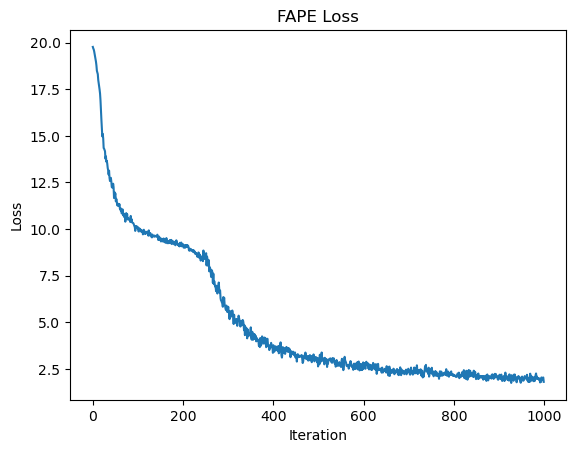

In [27]:
flow_model = FlowModel(FLOW_MODEL_CONFIG)
optimizer = torch.optim.Adam(flow_model.parameters(), lr=1e-4)

# TODO: create an SE(3) transformer that can be used to overfit on the able fold.
r = ur.Rigid.identity(shape=(batch_size, num_residues)) # type: ignore
node_mask = torch.ones(batch_size, num_residues, dtype=torch.float)
diffuse_mask = node_mask.clone()

losses = []
for epoch in range(1000):
    optimizer.zero_grad()

    pred_trans, pred_rotmat = flow_model(r, node_mask, diffuse_mask).values()
    loss = compute_fape(
        pred_frames = ur.Rigid(ur.Rotation(rot_mats=pred_rotmat), pred_trans),
        target_frames=ur.Rigid(ur.Rotation(rot_mats=target_frames[None, ...]), target_bb_coords[:, 1][None, ...]),
        frames_mask=node_mask,
        pred_positions=pred_trans,
        target_positions=target_bb_coords[:, 1][None, ...],
        positions_mask=node_mask,
        length_scale=1.0,
    )
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    plot_loss(losses)

In [28]:
pred_trans, pred_rotmat = flow_model(r, node_mask, diffuse_mask).values()

In [29]:
import plotly.express as px
import plotly.graph_objects as go
reconstructed = px.scatter_3d(x=pred_trans[:, :, 0].flatten().detach().numpy(), y=pred_trans[:, :, 1].flatten().detach().numpy(), z=pred_trans[:, :, 2].flatten().detach().numpy())
reconstructed.update_traces(marker=dict(size=5, color='blue'))

reconstructed.add_trace(
    go.Scatter3d(
        x=target_bb_coords[:, 1][:, 0].flatten().detach().numpy(),
        y=target_bb_coords[:, 1][:, 1].flatten().detach().numpy(),
        z=target_bb_coords[:, 1][:, 2].flatten().detach().numpy(),
        mode='markers',
        marker=dict(
            size=5,
            color='red',
        )
    )
)